<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/DanielCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import cv2
from PIL import Image
import os
from math import ceil
 
import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image_dataset_from_directory
 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

In [2]:
def loadImages(path):
    # list with paths of all images in the folder
    f_paths = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    # list with file names of the images
    f_names = [ os.path.basename(i) for i in f_paths ]
    # list with images
    # images = [ cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in files_path ] # cv read takes too long!
    images = [ plt.imread(i) for i in f_paths ]

    return f_names, images


def loadAnnotations(path):
  table = pd.read_csv(path)
  # file_names = list(table[['file_name']])
  f_names = [x[0] for x in table.values] #read colum 0
  annotations = np.asarray(table[['annotation']]).ravel()
  return f_names, annotations
 

def buildDataset(f_names, annotations, img_names, images):
  img_set = [] # empty list
  for i in range(len(f_names)):
    img_dict = {} # empty dictionary
    try:
      # find image name in annotation file
      idx = f_names.index(img_names[i])
      # create dictionary and add it to the list
      img_dict['file_name'] = f_names[i]
      img_dict['annotation'] = annotations[i]
      img_dict['image'] = images[i]
      img_set.append(img_dict)
    except:
      print("Image " + img_names[i] + " not found in annotations file!")
  
  return img_set


def reduceImages(images, imgNewSz):
  #Reduce the images by pixel size
  reduced_images = []
  for i in images:
    rimg = cv2.resize(i, (imgNewSz,imgNewSz), interpolation = cv2.INTER_LINEAR)
    # rimg = cv2.resize(i, None, fx=ratio, fy=ratio, interpolation = cv2.INTER_AREA)
    reduced_images.append(rimg)

  reduced_images = np.array(reduced_images)
  return reduced_images


# Histogram equalization
# https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def histEqualization(dataset):
  equ_dataset = dataset # copy input dataset
  for n in range(len(dataset)):
    # convert to YUV
    img_yuv = cv2.cvtColor(dataset[n]['image'], cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    equ_dataset[n]['image']  = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  return equ_dataset


def countClasses(dataset):
  labels = np.asarray( [d['annotation'] for d in dataset] )
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("") # enter


def countLabels(labels):
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("") # enter

In [3]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [4]:
# Training and validation data generator
datagen = ImageDataGenerator(
  rescale=1./255,
	rotation_range=30,
	zoom_range=0.15, # [1-zoom_range,1+zoom_range]
	# width_shift_range=0.2,
	# height_shift_range=0.2,
	# shear_range=0.15,
  brightness_range=[0.5,1.5],
	horizontal_flip=True,
	fill_mode="reflect") #  nearest

# # Test data generator
# test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# datagen

base_path = "drive/My Drive/ECE_542-Project_1/"
datasets_paths = [ os.path.join(base_path,'data/test/'),
                   os.path.join(base_path,'data/train/'),
                   os.path.join(base_path,'data/validation/') ]

img_size = (224,224)
b_size = 32

# # load and iterate test dataset
# test_it = test_datagen.flow_from_directory(datasets_paths[0],  batch_size=100, target_size=img_size)
# load and iterate training dataset
train_it = datagen.flow_from_directory(datasets_paths[1], batch_size=b_size, target_size=img_size)
# load and iterate validation dataset
val_it = datagen.flow_from_directory(datasets_paths[2],  batch_size=b_size, target_size=img_size)


Found 820 images belonging to 5 classes.
Found 355 images belonging to 5 classes.


(32, 224, 224, 3)
(32, 5)


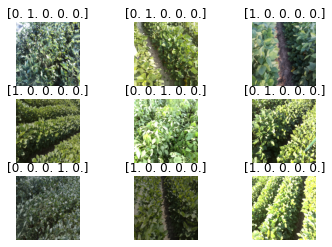

In [6]:
# Plot images from dataset
gen_imgs, gen_lbls = next(train_it)
print(gen_imgs.shape)
print(gen_lbls.shape)

# Plot 9 images
NUM_IMG = 9 
for i, (image, label) in enumerate(zip(gen_imgs,gen_lbls)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(str(label))
  plt.axis("off")
  if i >= NUM_IMG-1:
    break

In [7]:
# Class weights 
# See Dataset.ipybn for details of calculation
c_weights = {0: 0.5015290519877675, 
             1: 0.7592592592592593, 
             2: 2.1298701298701297, 
             3: 2.1298701298701297, 
             4: 1.3333333333333333}
print(c_weights)

{0: 0.5015290519877675, 1: 0.7592592592592593, 2: 2.1298701298701297, 3: 2.1298701298701297, 4: 1.3333333333333333}


In [8]:
# # Defining Base CNN Model
# def define_base_model(height, width, rate):
#     model = Sequential()
 
#     model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
#     #model.add(Dropout(rate))
#     #model.add(MaxPooling2D((2, 2)))
 
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(rate))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(rate))    
#     model.add(Dense(5, activation='softmax'))
 
#     return model


In [9]:
# Transfer learning

# loading the vgg16 model
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images
vgg = VGG16(input_shape=(img_size[0], img_size[1], 3), include_top=True) # True=include FC layers

# Freeze model
for layer in (vgg.layers)[:19]: # Freeze all convolutional layers
    # print(layer)
    layer.trainable = False

# Replace vgg output layer
x= vgg.layers[-2].output
prediction = Dense(5, activation="softmax")(x) # 5 classes

# x = Flatten()(vgg.output)
# prediction = Dense(5, activation='softmax')(x) # 5 classes

# Creating instance
model = Model(inputs = vgg.input, outputs = prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])


# summarize the model
model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

In [11]:
# Train the model

history = model.fit(
    train_it,
    steps_per_epoch = train_it.samples//train_it.batch_size,
    validation_data=val_it,
    validation_steps = val_it.samples//val_it.batch_size,
    epochs = 30,
    class_weight=c_weights, 
    verbose=1)

Epoch 1/30
25/25 [==============================] - 300s 12s/step - loss: 9.1719 - categorical_accuracy: 0.2437 - val_loss: 1.3407 - val_categorical_accuracy: 0.3778
Epoch 2/30
25/25 [==============================] - 24s 972ms/step - loss: 1.4197 - categorical_accuracy: 0.3832 - val_loss: 1.0783 - val_categorical_accuracy: 0.5511
Epoch 3/30
25/25 [==============================] - 24s 971ms/step - loss: 1.1710 - categorical_accuracy: 0.5381 - val_loss: 0.9901 - val_categorical_accuracy: 0.5824
Epoch 4/30
25/25 [==============================] - 24s 970ms/step - loss: 1.0089 - categorical_accuracy: 0.5546 - val_loss: 0.8253 - val_categorical_accuracy: 0.6364
Epoch 5/30
25/25 [==============================] - 24s 978ms/step - loss: 0.9307 - categorical_accuracy: 0.6129 - val_loss: 0.7753 - val_categorical_accuracy: 0.7131
Epoch 6/30
25/25 [==============================] - 24s 977ms/step - loss: 0.8441 - categorical_accuracy: 0.6269 - val_loss: 0.7537 - val_categorical_accuracy: 0.7188

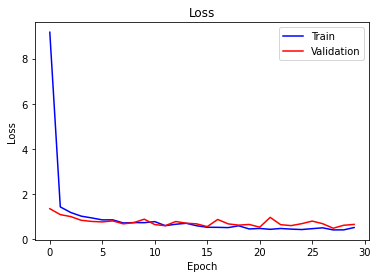

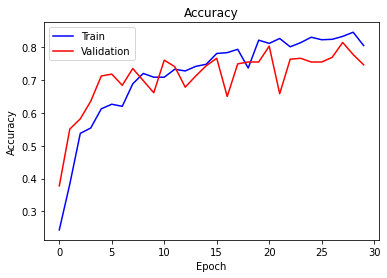

In [12]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
 
# Plotting results of training
plot_history(history)

Epoch 1/5
25/25 [==============================] - 27s 1s/step - loss: 0.5342 - categorical_accuracy: 0.7925 - val_loss: 0.6086 - val_categorical_accuracy: 0.7784
Epoch 2/5
25/25 [==============================] - 28s 1s/step - loss: 0.3463 - categorical_accuracy: 0.8820 - val_loss: 0.5199 - val_categorical_accuracy: 0.8267
Epoch 3/5
25/25 [==============================] - 27s 1s/step - loss: 0.2750 - categorical_accuracy: 0.8883 - val_loss: 0.5920 - val_categorical_accuracy: 0.7926
Epoch 4/5
25/25 [==============================] - 27s 1s/step - loss: 0.3236 - categorical_accuracy: 0.8604 - val_loss: 0.7111 - val_categorical_accuracy: 0.7386
Epoch 5/5
25/25 [==============================] - 27s 1s/step - loss: 0.3573 - categorical_accuracy: 0.8718 - val_loss: 0.7284 - val_categorical_accuracy: 0.6960


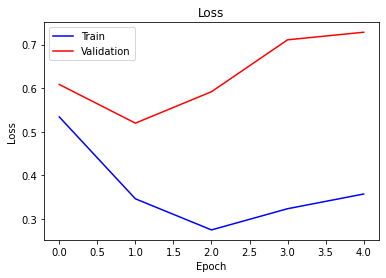

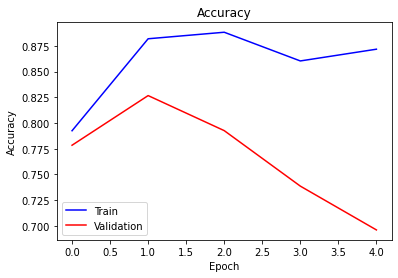

In [13]:
# Fine tunning

# Freeze model
vgg.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.00001),
                    metrics=['categorical_accuracy'])

history1 = model.fit(
    train_it,
    steps_per_epoch = train_it.samples//train_it.batch_size,
    validation_data=val_it,
    validation_steps = val_it.samples//val_it.batch_size,
    epochs = 5,
    class_weight=c_weights, 
    verbose=1)

# Plotting results
plot_history(history1)

In [14]:
# Training set

# Load training dataset in a single batch
train_ds = image_dataset_from_directory(datasets_paths[1], batch_size=820, image_size=img_size, label_mode='int', shuffle='False')
data_train, labels_train = next(iter(train_ds))
countLabels(labels_train)

base_results = model.predict(data_train)
base_results = np.argmax(base_results,axis=1)

accuracy = np.sum(base_results == labels_train)/len(base_results)
print("Accuracy training set = %0.2f" %accuracy)
countLabels(base_results)

# F1 Score
base_f1_score = f1_score(labels_train, base_results, average=None)
print(base_f1_score)

Found 820 files belonging to 5 classes.
Class 0: 327
Class 1: 216
Class 2: 77
Class 3: 77
Class 4: 123
 Total : 820

Accuracy training set = 0.51
Class 0: 526
Class 1: 147
Class 2: 89
Class 3: 55
Class 4: 3
 Total : 820

[0.72450176 0.46280992 0.19277108 0.12121212 0.04761905]


In [18]:
# Validation set

# Load training dataset in a single batch
valid_ds = image_dataset_from_directory(datasets_paths[2], batch_size=355, image_size=img_size, label_mode='int', shuffle='False')
data_valid, labels_valid = next(iter(valid_ds))
countLabels(labels_valid)

base_results = model.predict(data_valid)
base_results = np.argmax(base_results,axis=1)

accuracy = np.sum(base_results == labels_valid)/len(base_results)
print("Accuracy validation set = %0.2f" %accuracy)
countLabels(base_results)

# F1 Score
base_f1_score = f1_score(labels_valid, base_results, average=None)
print(base_f1_score)

Found 355 files belonging to 5 classes.
Class 0: 141
Class 1: 93
Class 2: 33
Class 3: 34
Class 4: 54
 Total : 355

Accuracy validation set = 0.45
Class 0: 238
Class 1: 71
Class 2: 37
Class 3: 9
Class 4: 0
 Total : 355

[0.65435356 0.34146341 0.2        0.04651163 0.        ]


In [16]:
# Test set

# Load test dataset in a single batch
test_ds = image_dataset_from_directory(datasets_paths[0], batch_size=100, image_size=img_size, label_mode='int', shuffle='False')
pre_test_images, pre_test_labels = next(iter(test_ds))
countLabels(pre_test_labels)

pre_test_results = model.predict(pre_test_images)
pre_test_results = np.argmax(pre_test_results,axis=1)

accuracy = np.sum(pre_test_results == pre_test_labels)/len(pre_test_labels)
print("Accuracy test set = %0.2f" %accuracy)
countLabels(pre_test_results)

# F1 Score
trueY = pre_test_labels
test_f1_score = f1_score(trueY, pre_test_results, average=None)
print(test_f1_score)

# Uncomment to save trained model
# model.save( os.path.join(base_path,'vgg16_model') )

Found 100 files belonging to 5 classes.
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
 Total : 100

Accuracy test set = 0.37
Class 0: 50
Class 1: 24
Class 2: 13
Class 3: 12
Class 4: 1
 Total : 100

[0.54285714 0.45454545 0.3030303  0.125      0.0952381 ]


In [17]:
# Generate CSV
test_path = "/content/drive/My Drive/ECE_542-Project_1/TestData-20201017T151905Z-001.zip"
 
zip1 = zipfile.ZipFile(test_path)
listOfFileNames1 = sorted(zip1.namelist())

# Remove 'Directory name'
file_name = []
for f in listOfFileNames1:
  file_name.append(f.replace('TestData/',''))
# print(file_name)
 
#Create array of test data
test = []
for file in listOfFileNames1:
  if file.endswith('.jpg'):
    img1 = plt.imread(zip1.open(file))
    test.append(img1)
  
test = np.array(test)

test_images = reduceImages(test, img_size[0])
# print(test_images.shape)
test_results = model.predict(test_images)
test_results = np.argmax(test_results,axis=1)

countLabels(test_results)

# Generate CSV file
data = {'file_name': file_name,'annotation': test_results  }
export_data = pd.DataFrame(data, columns=['file_name', 'annotation'])
export_data.to_csv (r'/content/drive/My Drive/ECE_542-Project_1/prediction_vgg16.csv', index = False, header=True)
print(export_data)

Class 0: 113
Class 1: 62
Class 2: 19
Class 3: 6
Class 4: 0
 Total : 200

      file_name  annotation
0    020031.jpg           0
1    020244.jpg           2
2    020446.jpg           0
3    020597.jpg           1
4    020693.jpg           1
..          ...         ...
195  029650.jpg           0
196  029787.jpg           3
197  029841.jpg           0
198  029866.jpg           1
199  029897.jpg           0

[200 rows x 2 columns]
